In [1]:
from skimage.morphology import skeletonize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from scipy import stats
import math

from skimage.util import img_as_bool, img_as_ubyte
from skimage.morphology import erosion as erode
from skimage.morphology import closing
from skimage.morphology import disk

from scipy.ndimage import label as scipylabel

from skimage.measure import regionprops
import numpy as np
import matplotlib.pyplot as plt

import os
import fnmatch

import ipywidgets as widgets
from ipywidgets import interact

from datetime import datetime 
import pickle

import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pandas as pd
import matplotlib.colors as colors

## For zc mac
#img = mpimg.imread(r'/Users/zackcohen/Dropbox/lily project/090120 sarahs original images/binarized slices/1736 mask only.JPG')
## For zc PC
#img = mpimg.imread(r'C:\Users\zackc\Dropbox\lily project\090120 sarahs original images\binarized slices\1736 mask only.JPG')

In [10]:
def load_saved_data(file_nameI):
    # Load saved data for a given tepal
    # The file loads the variable "saved_data".
    # The first element of "saved_data" is the dict "total_output_dict" (total_output_dict[5] = [thickness_list, thickness_pixels_list, interval_list, slope_list, Xskel, Yskel] for the 5th slice in the given tepal)
    # THe second element of "saved_data" is the list "tepal_list" (tepal_list = list of images (np boolean arrays) of slices of the given tepal)
    infile = open(file_nameI,'rb')
    saved_data = pickle.load(infile)
    #total_output_dict, tepal_list = save_data
    infile.close()
    return(saved_data)

def max_seperation(Xvals, Yvals):
    # Given points on a tepal slice's skeleton, find the 2 points that are maximally distant from each other
    # Xvals and Yvals are lists of X and Y coordinates of the pixels along the skeleton
    max_distance = -1
    x_MAX = []
    y_MAX = []
    for i in range(len(Xvals)):
        for ii in range(len(Xvals)):
            if ii > i:
                distance = ((Xvals[i] - Xvals[ii])**2 + (Yvals[i] - Yvals[ii])**2)**.5
                if distance > max_distance:
                    max_distance = distance
                    x_MAX = [Xvals[i],Xvals[ii]]
                    Y_MAX = [Yvals[i],Yvals[ii]]
    return(max_distance, x_MAX, Y_MAX)

def widest_slice_of_a_given_tepal(tepalI, pixels_to_mm):
    # Calculate the maximum width between 2 points on a tepal slice's skeleton.  Do this for all slices of that tepal
    # tepalI = all data for tepalI (tepalI = [total_output_dict, tepal_list])
    # pixels_to_mm = = list with the same number of elements as images in the set.  Each element is the pixel:mm ratio for the image with that index
    width_vals = []
    total_output_dict, tepal_list = tepalI
    for i in range(len(tepal_list)):
        thickness_list, thickness_pixels_list, interval_list, slope_list, Xskel, Yskel = total_output_dict[i]
        max_distance_pixels, x_MAX, Y_MAX = max_seperation(Xskel, Yskel)
        max_distance_mm = max_distance_pixels/pixels_to_mm[i]
        width_vals.append(max_distance_mm)
    return(width_vals)

def widest_slices_for_all_tepals(tepalA, tepalB, tepalC, pixels_to_mm):
    # For each tepal, identify the image that contains the widest slice of that tepal.  Width = separation between 2 points on the tepal slice's skeleton
    # return the indices_for_widest_slice = List with an element for each tepal.  Each element is the index corresponding to the image for the widest slice of that tepal
    # return widest_slice_widths = List with an element for each tepal.  Each element is the width of the widest slice of that tepal
    # return b_vals = List with an element for each tepal.  Each element has 1/2 the maximum distance between 2 points on a slice's skeleton for that tepal.  Units = milimeters)
    indices_for_widest_slices = []
    widest_slice_widths = []
    b_vals = []
    for tI in [tepalA, tepalB, tepalC]:
        width_vals = widest_slice_of_a_given_tepal(tI, pixels_to_mm)
        indices_for_widest_slices.append(width_vals.index(np.max(width_vals)))
        widest_slice_widths.append(np.max(width_vals))
        b_vals.append(np.max(width_vals)/2.)
            
    return(indices_for_widest_slices, widest_slice_widths, b_vals)

def project_u_onto_v(u, v):
    # Calculate the component of u along v
    # Both u and v have origin at the endpoint of the max seperation line
    # u = vector to a point along the skeleton (u = [x,y])
    # v = vector to the other end of the max seperation line (v = [x,y])
    dot_product = u[0]*v[0] + u[1]*v[1]
    magnitudeV = (v[0]*v[0] + v[1]*v[1])**.5
    comp = dot_product/magnitudeV
    return(comp)

def shift_origin(v1, origin):
    # take vector "v1", find it's coordinates in a new coordinate system with the point "origin" at the origin
    # v1 = vector from the (0,0) origin.  So v1 = [x, y]
    # origin = coordinates for the new origin.  So origin = [x, y]
    v1_prime = [v1[0]-origin[0], v1[1]-origin[1]]
    return(v1_prime)

def get_unshifted_Y_coords(skelX, skelY, xSep, ySep):
    # Find the component of each point on the skeleton that lies along the line of max seperation
    # skelX = list of X coordinates for points on the skeleton (image axes)
    # skelY = list of Y coordinates for points on the skeleton (image axes)
    # xSep = list of X coordinates for the endpoints of the max seperation line (image axes)
    # ySep = list of Y coordinates for the endpoints of the max seperation line (image axes)
    new_origin = [xSep[0],ySep[0]]
    shifted_max_sep_endpoint = shift_origin([xSep[1],ySep[1]], new_origin)
    shifted_skel = []
    projections = []
    for i in range(len(skelX)):
        shifted_skel.append(shift_origin([skelX[i],skelY[i]], new_origin))
        projections.append(project_u_onto_v(shifted_skel[i], shifted_max_sep_endpoint))
    return(projections)

def shift_Y_coords(unshifted_y_coords, new_origin):
    # unshifted_y_coords = list containing the components along the max seperation line for each point on a skeleton.  The origin is the endpoint.
    # new_origin = coordinate in unshifted_y_coords that I want to become the new origin
    # return shifted_coords = coordinates for each point in the new coordinate system
    shifted_coords = [x - new_origin for x in unshifted_y_coords]
    return(shifted_coords)

def calculate_y_coordinates(skelX, skelY, xSep, ySep, b):
    # Given coordinates for a pixel along the skeleton of a single tepal slice, find the corresponding Y-axis coordinate
    # I am defining the Y-axis as the line between maximally seperated points on that skeleton
    # Y = 0 is the midpoint of the max separation line
    
    # skelX and skelY are lists of the x and y coordinates (respectively) of pixels on a tepal slice's skeleton
    # xSep and ySep are lists of the x and y coordinates (respectively) for the maximally seperated points on that skeleton
    # b = 1/2 length of the max separation line
    
    # Mathematical procedure for doing this:
    # 1) Shift origin to one of the endpoints of the max seperation line
    # 2) Find coordinates on these new axes for a point along the skeleton (u), and the other endpoint of the max seperation line (v)
    # 3) Find the component of u along v.  This is the Y-axis coordinate for that point (with origin at endpoint of max seperation line)
    # 4) Repeat this for every point along the skeleton
    # 5) The desired origin along the max seperation line corresponds to the midpoint of that line.  So find the Y-coordinate of this midpoint, and subtract it from the Y-coordinate of every other point to get desired Y-coordinates

    proj1 = get_unshifted_Y_coords(skelX, skelY, xSep, ySep)
    Y_coords = shift_Y_coords(proj1, b)
    return(Y_coords)

def fit_thickness_vs_y_for_a_given_tepal(tepalA, I, px_mmI, a, b, index_for_widest_slice, slice_thickness, t0_index):
    # For slice "I" of a given tepal, calculate the model prediction for thickness vs Y-coordinate
    # tepalA = all data for tepalA (tepalA = [total_output_dict, tepal_list])
    # I = the index for which slice to use
    # px_mmI = the px:mm ratio for image I
    # a = the a value for tepalA
    # b = the b value for tepalA
    # index_for_widest_slice = the index for the widest slice of tepalA
    # slice_thickness = thickness in mm for all slices in this set
    # t0_index = index for points along the skeleton, where index = 0 gives the thickest point, and index = -1 gives the thinnest point.  We need this to prevent defining t0 based on unusually large thickness values
    total_output_dict, tepal_list = tepalA
    thickness_list, thickness_pixels_list, interval_list, slope_list, Xskel, Yskel = total_output_dict[I]
    thickest_pixel_along_tepalA_skeleton = thickness_list.index(np.max([x if x is not None else -1 for x in thickness_list]))
    x = (I - index_for_widest_slice)*slice_thickness
    max_distance, x_MAX, y_MAX = max_seperation(Xskel, Yskel)
    Y_pixels = calculate_y_coordinates(Xskel, Yskel, x_MAX, y_MAX, b*px_mmI)
    
    # Explicitly identify the 2 maximally seperated points on the skeleton
    p1 = (x_MAX[0], y_MAX[0])
    p2 = (x_MAX[1], y_MAX[1])

    # Determine the values to plot for comparisson of the data and model
    # I want to exlude points on the skeleton that lie before or after the maximally seperated points.  So use the "plot these" variable to achieve this.
    Y_mm = []
    thickness_mm = []
    t = []
    plot_these = False
    
    # Choose t0 so that it is the thickness at the thickest part of this slice of this tepal
    t0 = sorted([x if x is not None else -1 for x in thickness_list], reverse = True)[t0_index]/px_mmI
    
    for i in range(len(Y_pixels)):
        if (Xskel[i], Yskel[i]) == p1 or (Xskel[i], Yskel[i]) == p2:
            plot_these = not plot_these
        if plot_these == True and thickness_list[i] is not None:
            yi = Y_pixels[i]/px_mmI
            Y_mm.append(yi)
            thickness_mm.append(thickness_list[i]/px_mmI)
            t.append(model_equation(a, b, t0, x, yi))
    return(Y_mm, thickness_mm, t, np.max([t0, np.max(thickness_mm)]))

def model_equation(a, b, t0, x, y):
    # from Liang and Mahadevan 2011
    # t = thickness at any given point along tepal
    # t0 = maximum thickness of a tepal
    # a = (number of slices from begining to the widest slides) * slice thickness (origin = widest slice)
    # b= 1/2 of the maximum seperation between 2 points on a skeleton, across all tepal slices
    # x = slice# * slice thickness (origin = widest slice)
    # y = distance along the max seperation line for a given tepal (origin = halfway across the line)
    t=t0*(1-(x/a)**2-(y/b)**2)
    return(t)

def fit_thickness_vs_y_for_all_tepals(tepalA, tepalB, tepalC, I, px_mmI, a_vals, b_vals, indices_for_widest_slices, slice_thickness, t0_indices):
    # For image with index "I", calculate the model prediction for thickness vs Y-coordinate for each tepal
    # tepalA = all data for tepalA (tepalA = [total_output_dict, tepal_list])
    # I = the index for which slice to use
    # px_mmI = the px:mm ratio for image I
    # a_vals = list where elements are the a values for each tepal.  Units = mm
    # b_vals = list where elements are the b values for each tepal. Units = mm
    # indices_for_widest_slices = list where elements are the index for the widest slice of that tepal
    # slice_thickness = thickness in mm for all slices in this set
    y = []
    thickness_data = []
    thickness_fit = []
    t0_vals = []
    tepal_list = [tepalA, tepalB, tepalC]
    for i in range(len(tepal_list)):
        Y_mm, thickness_mm, t, t0 = fit_thickness_vs_y_for_a_given_tepal(tepal_list[i], I, px_mmI, a_vals[i], b_vals[i], indices_for_widest_slices[i], slice_thickness, t0_indices[i])
        y.append(Y_mm)
        thickness_data.append(thickness_mm)
        thickness_fit.append(t)
        t0_vals.append(t0)
    return(y, thickness_data, thickness_fit, t0_vals)

def find_slope(xI, yI, axI, slope_offset, fit_rangeX):
    minX, maxX = fit_rangeX
    index_min = np.argmin(np.abs([a - minX for a in xI]))
    index_max = np.argmin(np.abs([a - maxX for a in xI]))
    fit_range = slice(index_min, index_max)
    xF = xI[fit_range]
    yF = yI[fit_range]
    slope, intercept, r_value, p_value, std_err = stats.linregress(xF, yF)
    yS = [slope*q + intercept + slope_offset for q in xF]
    axI.plot(xF, yS, linewidth = 10, color='k')
    #axI.annotate(str(np.round(slope,2)), (xF[0]*0, yF[0]*.1), color = 'k', fontsize = 50)
    

def plot_thickness_vs_Y(y, thickness_data, thickness_fit, t0_vals, b_vals, slope_offset, fit_range_lists):
    mpl.rcParams['axes.linewidth'] = 2.5
    fig, ax = plt.subplots(3, 1, figsize = (12, 12))
    for i in [0,1,2]:
        ax[i].plot(y[i], thickness_fit[i], color='#d73027', label = 'Model prediction', linewidth = 10)
        dc = '#4575b4'
        ax[i].plot(y[i], thickness_data[i], marker = 'o', markersize = 20, label = 'Lily data', markeredgewidth = 1, markerfacecolor=colors.to_rgba(dc, 0.2), markeredgecolor = dc, linestyle='')
        ax[i].plot(y[i], thickness_data[i], color=dc, linewidth = 1)
        ax[i].set_ylim([0, np.max(t0_vals)*1.1])
        ax[i].tick_params(axis='both',labelsize=50, length = 7, width = 2.5)
        ax[i].set_xlim([-1*b_vals[i]*1.1, b_vals[i]*1.1])
        ax[i].set_xticks([])
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        find_slope(y[i], thickness_data[i], ax[i], slope_offset[i], fit_range_lists[i])
    ax[2].set_xticks([-1*b_vals[i], 0, b_vals[i]])
    ax[2].set_xticklabels(['-b',0,'b'])
    #fSIZE = 35
    #plt.figtext(-.2,.25,'Semi-minor thickness (mm)', rotation = 90, size = fSIZE)
    #plt.figtext(.12,.045,'Y-axis (mm)', size = fSIZE)
    
def plot_max_thickness_vs_X(x, max_thickness_lists, a_vals):
    mpl.rcParams['axes.linewidth'] = 2.5
    fig, ax = plt.subplots(3, 1, figsize = (12, 12))
    for i in [0,1,2]:
        x_reverse = x[i][::-1]
        thickness_fit = []
        for xr in [-1*q for q in x_reverse]:
            thickness_fit.append(model_equation(a_vals[i], 1, np.max(max_thickness_lists[i][::-1]), xr, 0))
        ax[i].plot([-1*q for q in x_reverse], thickness_fit, color='#d73027', label = 'Model prediction', linewidth =10)
        dc = '#4575b4'
        ax[i].plot([-1*q for q in x_reverse], max_thickness_lists[i][::-1], marker = 'o', markersize = 20, label = 'Lily data', markeredgewidth = 1, markerfacecolor=colors.to_rgba(dc, 1.0), markeredgecolor = dc, linestyle='')
        ax[i].plot([-1*q for q in x_reverse], max_thickness_lists[i][::-1], color=dc, linewidth = 1)
        ax[i].set_ylim([0, np.amax(max_thickness_lists)*1.1])
        ax[i].tick_params(axis='both',labelsize=50, length = 7, width = 2.5)
        ax[i].set_xlim([0 - a_vals[i]*.1, a_vals[i]*1.1])
        ax[i].set_xticks([])
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
    ax[2].set_xticks([0, a_vals[i]])
    ax[2].set_xticklabels([0, 'a'])
    #fSIZE = 35
    #plt.figtext(-.2,.25,'Semi-major thickness (mm)', rotation = 90, size = fSIZE)
    #plt.figtext(.12,.045,'X-axis (mm)', size = fSIZE)

def import_scalebars(path1):
    df1 = pd.read_excel (path1, sheet_name='Sheet1')
    return(list(df1['pixels/mm']))
    

In [3]:
# Load thickness data from each tepal for a given set of lily images
tepal1 = load_saved_data('test_data_tepal1')
tepal2 = load_saved_data('test_data_tepal2')
tepal3 = load_saved_data('test_data_tepal3')

# Set the pixel:milimeter ratio for each image. px_mm = list with the same number of elements as images in the set.  Each element is the pixel:mm ratio for the image with that index
#path1 = r'C:/Users/zackcohen/Dropbox/lily project/100621 thickness analyses/tiger lily 2Aug2012/tiger lily 2Aug2012 scalebars.xlsx'
path1 = r'C:/Users/zackc/Dropbox/lily project/100621 thickness analyses/tiger lily 2Aug2012/tiger lily 2Aug2012 scalebars.xlsx'
px_mm = import_scalebars(path1)

# Set the thickness of each slice in this set. Units = mm.  
# For "big white 2013", "Thomas pink bud 2012", and "Tiger lily 2Aug2012": thickness per slice = ~3mm.  For "alba 2021" = ~1.8mm
slice_thickness = 3


In [4]:
# For the widest slice, calculate thickness vs Y coordinate for all 3 tepals.
# Also calculate the model fit for thickness vs Y coordinate for all 3 tepals in the widest slice
# The widest slice contains the tepal with the largest Y-axis separation between points on it's skeleton
# b = 1/2 of this maximal Y-axis separation

indices_for_widest_slices, widest_slice_widths, b_vals = widest_slices_for_all_tepals(tepal1, tepal2, tepal3, px_mm)
index_for_image_with_the_absolute_widest_slice = indices_for_widest_slices[widest_slice_widths.index(np.max(widest_slice_widths))]

# Calculate the value of the "a" parameter for each tepal.  "a" is given by (thickness per slice)*(number of slices from begining until widest slice).  Units = mm.
a_vals = [slice_thickness*x for x in indices_for_widest_slices]

t0_indices = [10, 10, 3]
y, thickness_data, thickness_fit, t0_vals = fit_thickness_vs_y_for_all_tepals(tepal1, tepal2, tepal3, index_for_image_with_the_absolute_widest_slice, px_mm[index_for_image_with_the_absolute_widest_slice], a_vals, b_vals,  indices_for_widest_slices, slice_thickness, t0_indices)



Tepal1: t0 = 2.128 mm
Tepal2: t0 = 2.248 mm
Tepal3: t0 = 1.977 mm


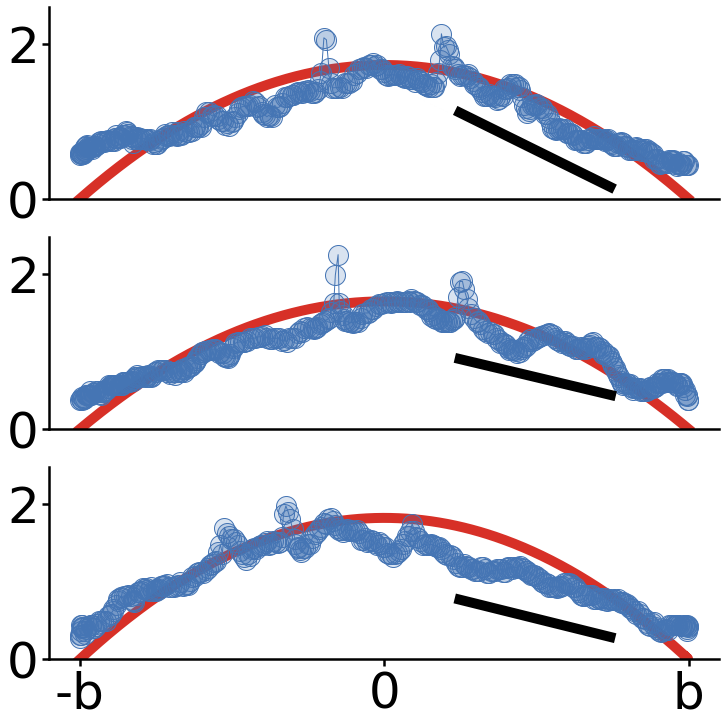

In [11]:
slope_offset = [-.5]*3
fit_range_lists = [[.25*q, .75*q] for q in b_vals]

plot_thickness_vs_Y(y, thickness_data, thickness_fit, t0_vals, b_vals, slope_offset, fit_range_lists)
for i in [0,1,2]:
    print('Tepal' + str(i+1) + ': t0 = ' + str(np.round(t0_vals[i],3)) + ' mm')

In [6]:
def calculate_max_thickness_for_a_given_tepal(tepalI, pixels_to_mm):
    # For a single tepal, calculate the "t0" parameter (t0 = maximum thickness of a tepal slice, across all slices of that tepal)
    # tepalI = all data for tepalI (tepalI = [total_output_dict, tepal_list])
    # pixels_to_mm = = list with the same number of elements as images in the set.  Each element is the pixel:mm ratio for the image with that index
    # return t0 in milimeter units (t0_mm)
    # return the index for the slice that has t0 (index_for_slice_with_max_thickness)
    # return a list where each element is the maximum thickness of the slice with that index (max_thickness_list)
    total_output_dict, tepal_list = tepalI
    max_thickness_list = []
    for i in range(len(total_output_dict)):
        thickness_list, thickness_pixels_list, interval_list, slope_list, Xskel, Yskel = total_output_dict[i]
        max_thickness_list.append(np.max([x/pixels_to_mm[i] if x is not None else -1 for x in thickness_list]))
    return(max_thickness_list)

def calculate_max_thickness_for_all_tepals(tepalA, tepalB, tepalC, pixels_to_mm):
    t0_vals = []
    max_thickness_lists = []
    for i in [tepalA, tepalB, tepalC]:
        max_thickness_list = calculate_max_thickness_for_a_given_tepal(i, pixels_to_mm)
        max_thickness_lists.append(max_thickness_list)
    return(max_thickness_lists)

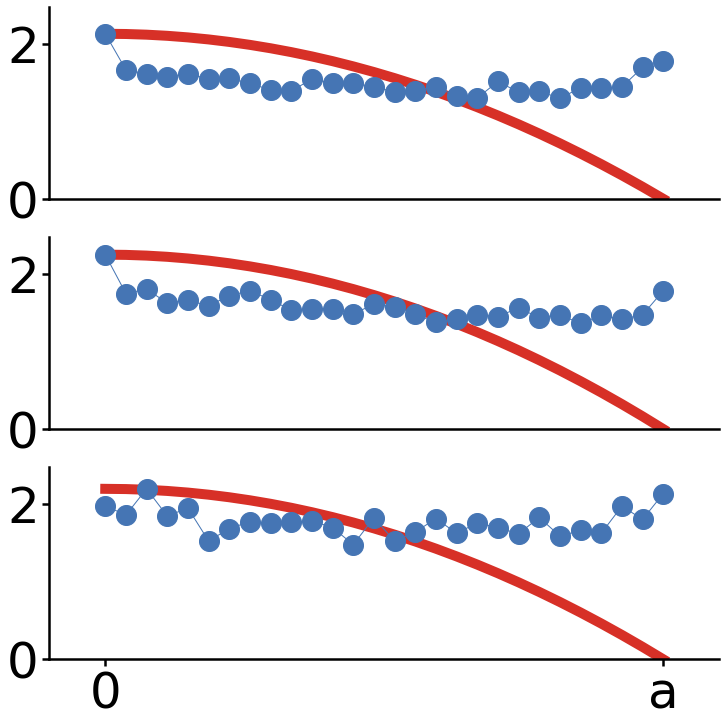

In [7]:
# Calculate maximum thickness vs X coordinate for all 3 tepals.
# The maximum thickness is the max thickness at any point on a tepal skeleton
max_thickness_lists = calculate_max_thickness_for_all_tepals(tepal1, tepal2, tepal3, px_mm)

# The X coordinate is basically the slice index times the slice thickness, and the zero point is the widest slice of that tepal
x = []
for i in [0,1,2]:
    xi = [slice_thickness*(x - indices_for_widest_slices[i]) for x in range(len(max_thickness_lists[i]))]
    x.append(xi)
#plot_max_thickness_vs_X_BACKWARDS(x, max_thickness_lists, a_vals)
plot_max_thickness_vs_X(x, max_thickness_lists, a_vals)
    